# Tied Margins

This notebook contains a counterexample with 5 candidates to Conjecture 6 when tied margins are allowed. 

In [1]:
from pref_voting.weighted_majority_graphs import MarginGraph
from pref_voting.generate_profiles import *
from pref_voting.margin_based_methods import *
from pref_voting.generate_weighted_majority_graphs import *
from itertools import permutations, chain, product, combinations

## Example from Figure 6 of Appendix A

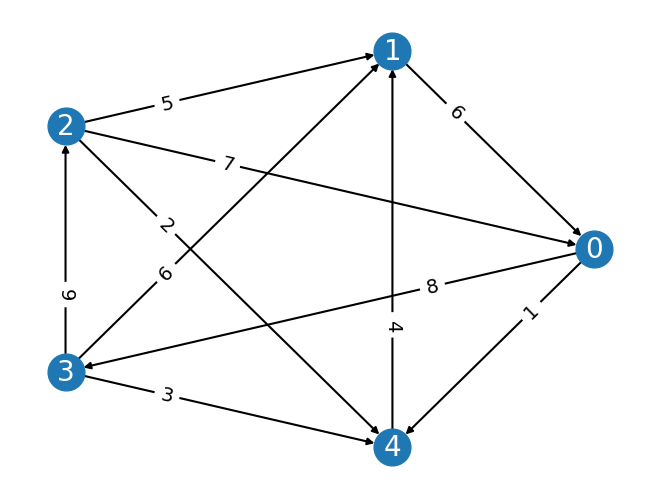

In [2]:
mg = MarginGraph(
    [0, 1, 2, 3, 4], [  
        (0, 4, 1),
        (2, 4, 2), 
        (3, 4, 3), 
        (4, 1, 4),
        (2, 1, 5), 
        (3, 1, 6), 
        (1, 0, 6), 
        (2, 0, 7), 
        (0, 3, 8),
        (3, 2, 9), 
    ])

mg.display()

In [3]:
simple_stable_voting.display(mg)
split_cycle.display(mg)


Simple Stable Voting winner is {1}
Split Cycle winners are {0, 4}


## Simple Stable Voting with Parallel Universe Tiebreaking

An implementation of Simple Stable Voting with Parallel Universe Tiebreaking (SSV-PUT) as described in Definition 15 from Appendix Z. 

In [4]:
def encode_weak_tournament(edata, candidates = None): 
    
    candidates = sorted(candidates) if candidates is not None else edata.candidates
    pairs = [(c1, c2) for c1 in candidates for c2 in candidates if c1 < c2]
    
    s = []
    for a, b in pairs: 
        if edata.majority_prefers(a, b): 
            s.append(1)
        elif edata.majority_prefers(b, a): 
            s.append(-1)
        elif edata.is_tied(a, b): 
            s.append(0)
            
    return s, candidates
    
def generate_binary_strings(n):
    return chain((n*(0,),), (l[0] * (0,) + sum(((1,) + (i-j-1) * (0,) for i, j in zip(l[1:], l[:-1])), ()) + (1,) + (n-l[-1]-1)*(0,) for k in range(1,n+1) for l in combinations(range(n), k)))

def edges_to_add_for_tournament(candidates, weak_tourn = None):
    
    weak_tourn = weak_tourn if weak_tourn is not None else [0] * (candidates * (candidates - 1))
    pairs = [(c1, c2) for c1 in candidates for c2 in candidates if c1 < c2]
    zero_indices = [idx for idx,b in enumerate(weak_tourn) if b == 0]
    
    edges_string = generate_binary_strings(len(zero_indices))

    for e_str in edges_string: 
        edges = list()
        for e_idx, e_byte in enumerate(e_str):
            if e_byte:
                edges.append((pairs[zero_indices[e_idx]][0], pairs[zero_indices[e_idx]][1]))
            else: 
                edges.append((pairs[zero_indices[e_idx]][1], pairs[zero_indices[e_idx]][0]))                
        yield edges
        

def linearize_edges(edata, curr_cands = None):
    
    curr_cands = curr_cands if curr_cands is not None else edata.candidates
    
    pos_edges = [(a, b) for a in curr_cands for b in curr_cands if edata.majority_prefers(a, b)]
    margins = list(set([edata.margin(a, b) for a, b in pos_edges]))
    sorted_margins = sorted(margins, reverse=True)
    sorted_pos_edges = [[e for e in pos_edges if edata.margin(e[0], e[1]) == m] for m in sorted_margins]
    
    new_pos_edge_lists = list(product(*[permutations(es) for es in sorted_pos_edges]))
    
    for _new_pos_edges in new_pos_edge_lists:
        new_pos_edges = flatten(_new_pos_edges)
        ewt, _ = encode_weak_tournament(edata, candidates = curr_cands)
        for _edges_to_add in edges_to_add_for_tournament(curr_cands, weak_tourn = ewt): 
            for edges_to_add in permutations(_edges_to_add): 
                _new_edges = new_pos_edges + list(edges_to_add)
                
                yield _new_edges + [(b, a) for a, b in reversed(_new_edges)]


In [5]:
def _simple_stable_voting_from_edgelist(edge_list, curr_cands = None, mem_sv_winners = {}): 
    '''
    Determine the Simple Stable Voting winners from an ordering of the edges while keeping track of the winners in any subprofiles checked during computation. 
    '''
    
    # curr_cands is the set of candidates who have not been removed
    curr_cands = curr_cands if not curr_cands is None else sorted(list(set([e[0] for e in edge_list] + [e[1] for e in edge_list]))) 
    
    sv_winners = list()
    
    sorted_matches =  [e for e in edge_list if e[0] in curr_cands and e[1] in curr_cands] 
    
    if len(curr_cands) == 1: 
        mem_sv_winners[tuple(curr_cands)] = curr_cands
        return curr_cands, mem_sv_winners
    for a, b in sorted_matches: 
        if a not in sv_winners:
            cands_minus_b = sorted([c for c in curr_cands if c!= b])
            if tuple(cands_minus_b) not in mem_sv_winners.keys(): 
                ws, mem_sv_winners = _simple_stable_voting_from_edgelist(edge_list, 
                                                                         curr_cands = cands_minus_b,
                                                                         mem_sv_winners = mem_sv_winners)
                mem_sv_winners[tuple(cands_minus_b)] = ws
            else: 
                ws = mem_sv_winners[tuple(cands_minus_b)]
            if a in ws:
                sv_winners.append(a)
        if len(sv_winners) > 0: 
            return sorted(sv_winners), mem_sv_winners

@vm(name="Simple Stable Voting PUT")
def simple_stable_voting_put(edata, curr_cands = None): 
    '''
    Determine the Simple Stable Voting PUT winners. 
    '''
    
    # curr_cands is the set of candidates who have not been removed
    curr_cands = curr_cands if not curr_cands is None else edata.candidates

    cw = edata.condorcet_winner(curr_cands = curr_cands)
    if cw is not None: 
        return [cw]
    else: 
    
        ssv_winners = list()
        for edge_list in linearize_edges(edata, curr_cands = curr_cands):
            ssv_ws = _simple_stable_voting_from_edgelist(edge_list, curr_cands = None, mem_sv_winners = {})[0]
            ssv_winners += ssv_ws
        return sorted(list(set(ssv_winners)))


In [6]:
simple_stable_voting_put.display(mg)

Simple Stable Voting PUT winners are {0, 4}
